# Sandbox notebook for data analysis and visualization

Author: Veikka Immonen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from PIL import Image

from tqdm import tqdm

import scienceplots

plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

from sklearn.model_selection import train_test_split

plt_original_resolution = plt.rcParams['figure.figsize']
plt_original_resolution

[3.5, 2.625]

## CytoSense

In [2]:
data_dir = Path('./data/CytoSense')
image_dir = data_dir / 'images'
profile_dir = data_dir / 'profiles'
annotations = pd.read_csv(data_dir / 'annotations.csv')
annotations

,X,class_name,has_image,has_profile
0,1,Aphanizomenon_flosaquae,True,False
1,2,Aphanizomenon_flosaquae,True,True
2,3,Aphanizomenon_flosaquae,True,True
3,4,Aphanizomenon_flosaquae,True,True
4,5,Aphanizomenon_flosaquae,True,True
...,...,...,...,...
14317,14353,Snowella-Woronichinia,True,False
14318,14354,Snowella-Woronichinia,True,False
14319,14355,Snowella-Woronichinia,True,False
14320,14356,Snowella-Woronichinia,True,False


### Statistics

Number of samples for each instance, how many of them are purely multimodal 
(images + all time series data)?

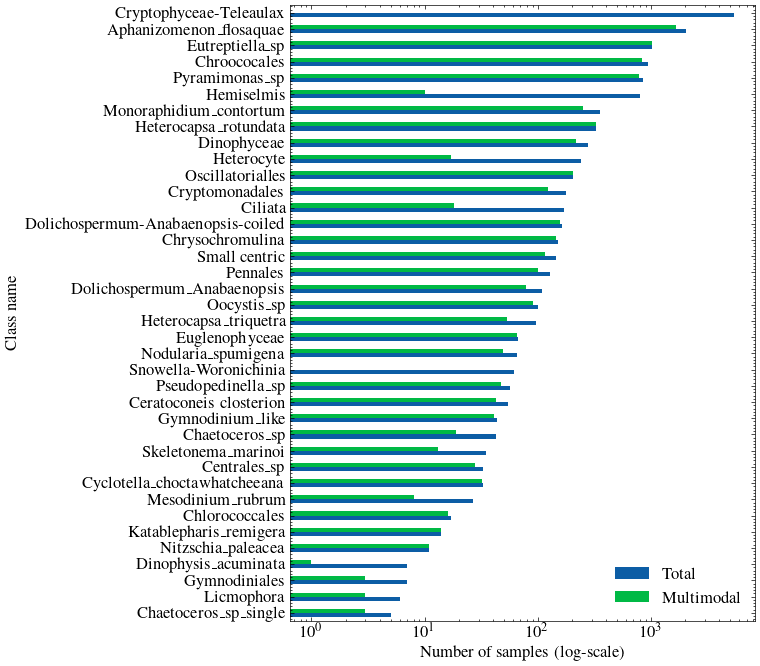

In [4]:
counter = Counter(annotations.class_name)

df = pd.DataFrame(
    index=annotations.class_name.unique(),
)

df['Total'] = counter.values()

for key in counter:
    counter[key] = 0

counter.update(annotations[~(annotations == False).any(axis=1)].class_name)
df['Multimodal'] = counter.values()

df.sort_values('Total').plot(kind='barh', figsize=(6, 8))
plt.xlabel('Number of samples (log-scale)')
plt.ylabel('Class name')
plt.xscale('log')

# plt.savefig(f'sample_counts.pdf')
plt.show()

Rough selection would be to exclude classes with less than 10 multimodal samples.

In [5]:
X = annotations[annotations.has_profile].X

def table_len(x):
    return pd.read_csv(profile_dir / f'{x}.csv').shape[0]

counter = Counter(list(map(table_len, X)))


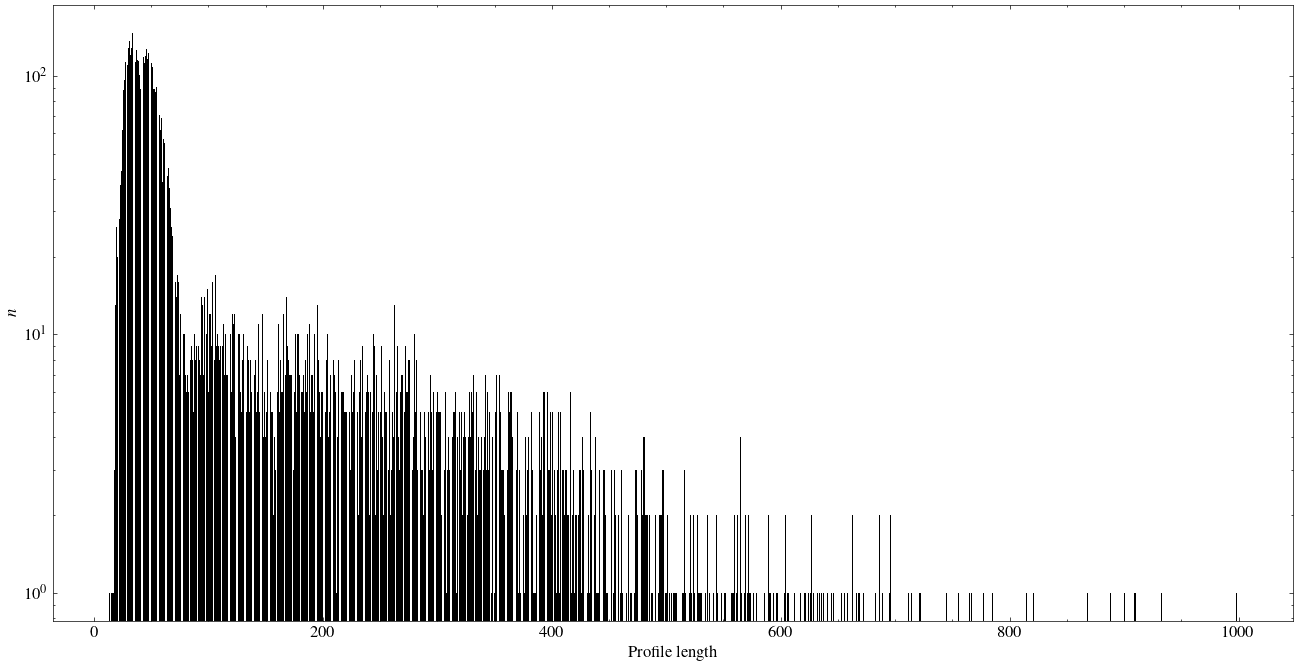

In [6]:

_, ax = plt.subplots(figsize=(16, 8))
ax.bar(*zip(*counter.items()), color='k')
# ax.set_xscale('log')
ax.set_xlabel('Profile length')
ax.set_ylabel('$n$')
ax.set_yscale('log')

### Visualization

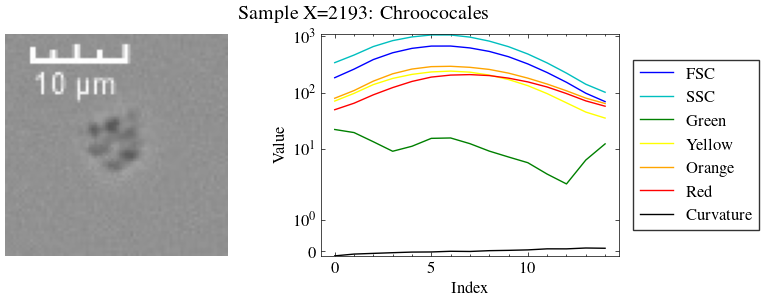

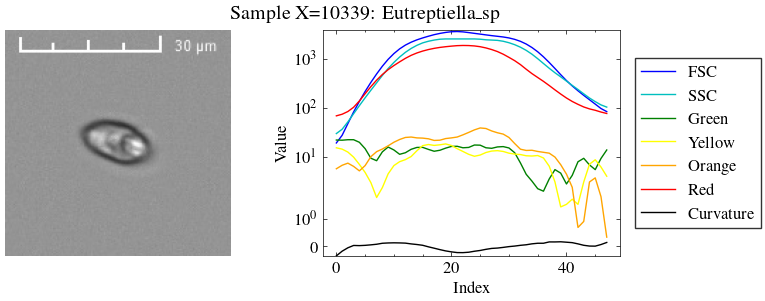

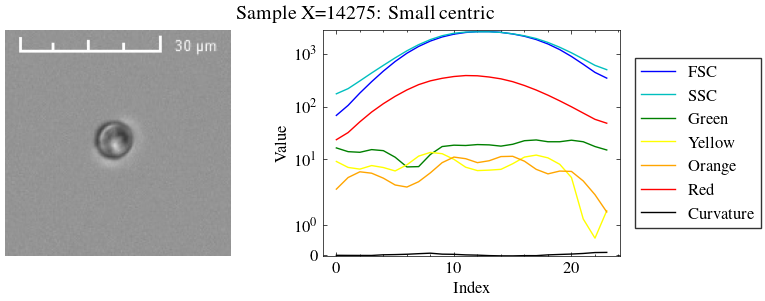

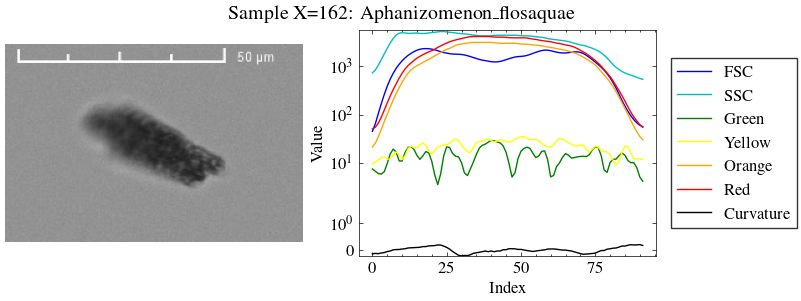

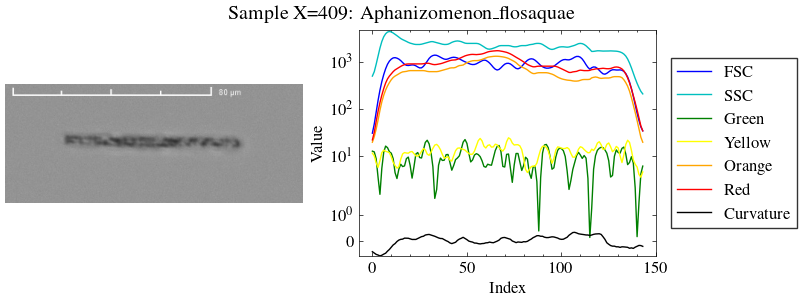

In [3]:
def visualize(sample):
    image = np.array(Image.open(image_dir / f"{sample.X}.jpg"))
    profile = pd.read_csv(profile_dir / f"{sample.X}.csv")

    styles = ['b', 'c', 'g', 'yellow', 'orange', 'r', 'k']

    fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained")

    ax1.imshow(image)
    ax1.set_axis_off()

    ax2 = profile.plot(ax=ax2, style=dict(zip(profile.columns, styles)))
    ax2.legend(loc=7, frameon=True, edgecolor='k', fancybox=False, bbox_to_anchor=(1.5, 0.5))
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Value')
    ax2.set_yscale('symlog')
    ax2.set_ylim([profile.min().min(), None])

    fig.set_size_inches(8, 3)
    
    plt.suptitle(f'Sample X={sample.X}: {sample.class_name}')
    plt.savefig(f'figures/{sample.X}.pdf')
    plt.show()

for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample(5).iterrows():
    visualize(sample)



In [9]:
profile = pd.read_csv(profile_dir / f"{sample.X}.csv")
profile.min().min()

NameError: name 'sample' is not defined

In [11]:
multimodal = annotations[(annotations.iloc[:, -2:] == True).all(axis=1)]
class_names, counts = np.unique(multimodal.class_name, return_counts=True)

idx = counts.argsort()[::-1]
class_names = class_names[idx]
counts = counts[idx]
print(counts)

train = pd.DataFrame(columns=multimodal.columns)
test = pd.DataFrame(columns=multimodal.columns)
valid = pd.DataFrame(columns=multimodal.columns)

size=15
for i in range(size):
    annot = multimodal[multimodal.class_name == class_names[i]]
    train_annot, test_annot = train_test_split(annot, train_size=50)
    valid_annot = test_annot.sample(10)
    train = pd.concat([train, train_annot])
    test = pd.concat([test, test_annot])
    valid = pd.concat([valid, valid_annot])

train.to_csv(data_dir / f'train_{size}.csv')
test.to_csv(data_dir / f'test_{size}.csv')
valid.to_csv(data_dir / f'valid_{size}.csv')

[1659 1016  834  792  329  253  219  203  156  146  122  116  101   91
   78   66   53   49   47   43   41   32   28   19   18   17   16   14
   13   11   10    8    3    3    3    1]


In [8]:
table = pd.read_csv('./data/CytoSense/Pulse-shapes_annotated_CS_images.csv')

In [9]:
table = table.iloc[:, -7:].dropna()
max_vals = table.max(0).to_numpy().astype(int)
min_vals = table.min(0).to_numpy().astype(int)

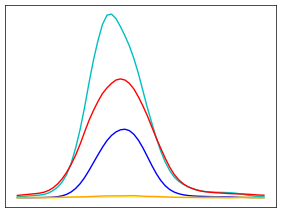

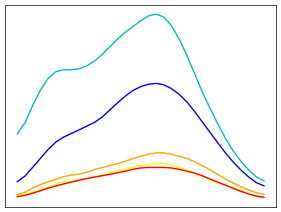

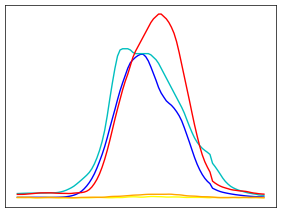

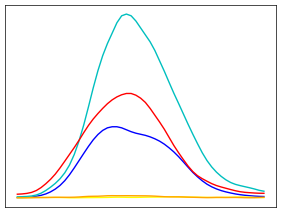

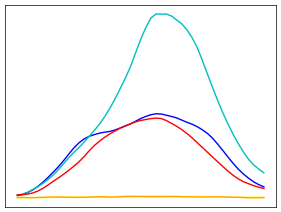

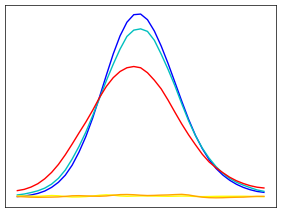

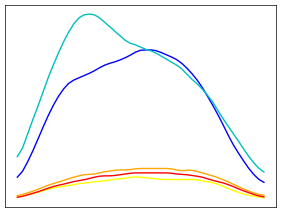

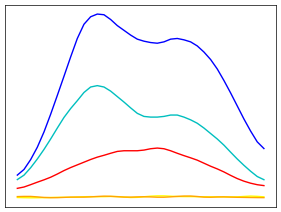

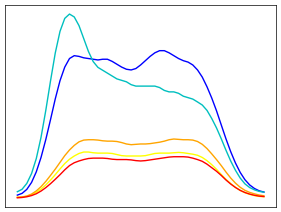

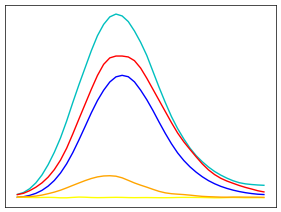

In [ ]:
    
for _, sample in annotations[annotations.iloc[:, -2:].T.all()].sample(20).iterrows():
    x = sample.X

    image = Image.open(image_dir / f"{x}.jpg")
    profile = pd.read_csv(profile_dir / f"{x}.csv")
    profile = profile.iloc[:, [0, 1, 3, 4, 5]]

    h, w = image.size

    if h == w:
        styles = ['b', 'c', 'yellow', 'orange', 'r']

        fig, ax = plt.subplots()


        profile = (profile - min_vals[[0, 1, 3, 4, 5]]) / (max_vals[[0, 1, 3, 4, 5]] - min_vals[[0, 1, 3, 4, 5]])
        # profile = np.log(profile + 1)
        
        ax = profile.plot(ax=ax, style=dict(zip(profile.columns, styles)))

        ax.legend().set_visible(False)
    
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # plt.savefig(f'figures/{x}_profile.pdf')
        # image.save(f'figures/{x}_image.png')

        plt.show()
